# Deep learning for time-series - Assignment 1

## Part A

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from tabulate import tabulate
from statsmodels.tsa.arima.model import ARIMA
import warnings

### A1. Exploratory analysis
- Plot y_t over time (clear labels). Describe trend/level changes/outliers.
- Add a simple smoothing overlay (moving average or exponential smoothing) only to highlight
structure (do not use it as the final model).

In [17]:
# Load data
y_raw = pd.read_csv("www_usage.csv")

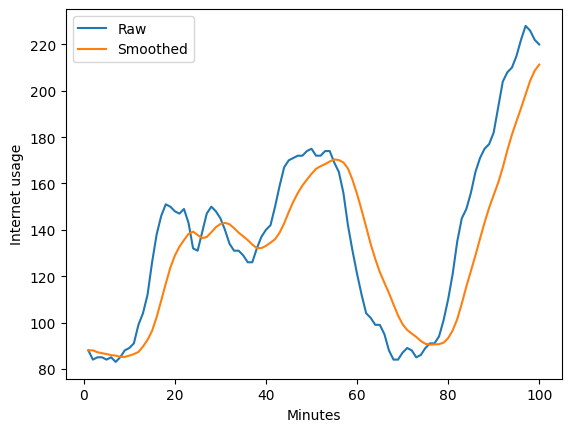

In [ ]:
df = y_raw.copy()

# Fit exponential smoothing
model = SimpleExpSmoothing(df["y"])
fit = model.fit(smoothing_level=0.2, optimized=False)
y_smooth = fit.fittedvalues

# Plot raw and smoothed series
plt.plot(df["ds"], df["y"], label="Raw")
plt.plot(df["ds"], y_smooth, label="Smoothed")
plt.xlabel("Minute")
plt.ylabel("Internet usage")
plt.legend()
plt.show()

The dataset looks non-stationary in both a strict and wide sense. It exhibits significant positive and negative trends in mean with slightly noisy behaviour. It is difficult to access whether the series is heteroscedastic through visual inspection and it does not seem to contain notable outliers.

The smoothed signal shows same non-stationarity but the seemingly noisy part is filtered out.

### A2. Select the differencing order $d$
- Test d = 0, 1, 2 in order. For each candidate: plot the differenced series and its ACF.
- Run stationarity tests: ADF (null: unit root / nonstationary) and KPSS (null: stationary).
- Choose the smallest d that makes the series look stationary and passes tests reasonably (avoid
over-differencing).
- Write 3–6 sentences explaining why your chosen d is appropriate.

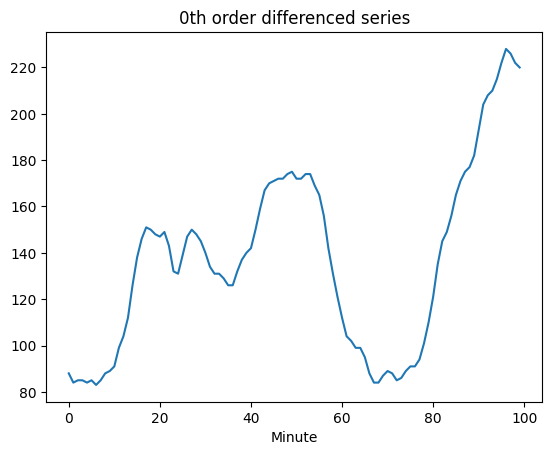

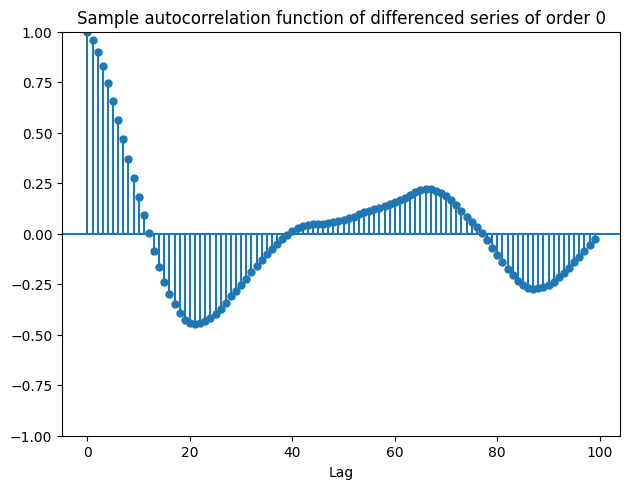

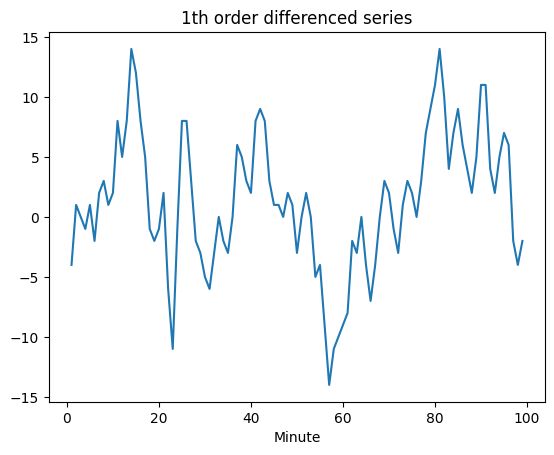

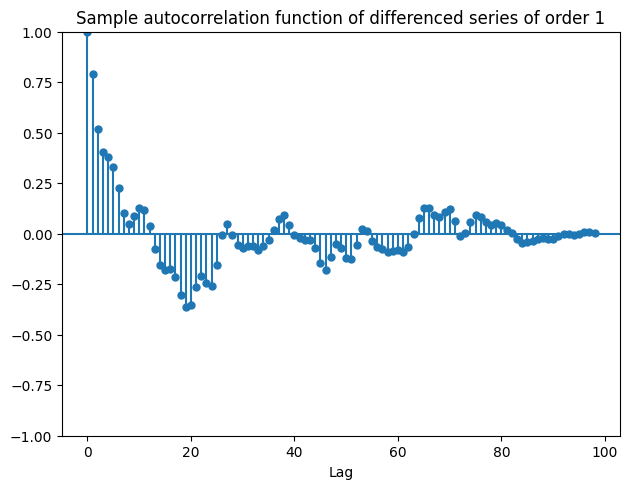

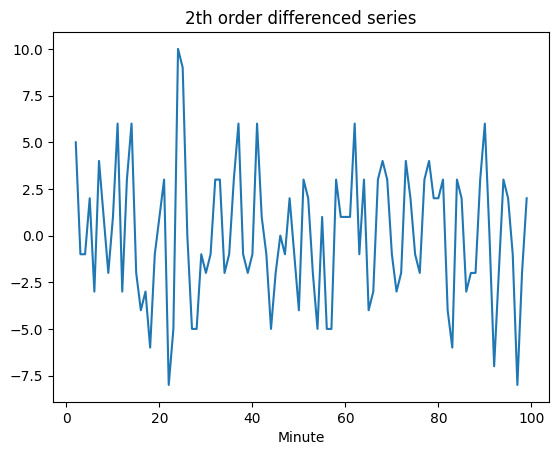

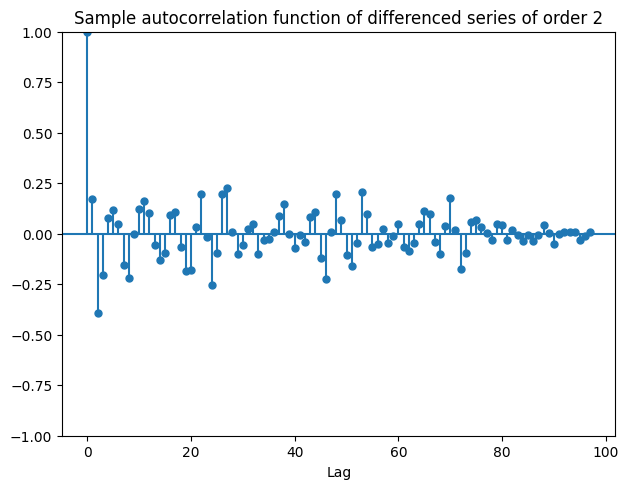

In [ ]:
df = y_raw.copy()

# Calculated differenced series
series = {}
series["0"] = df.y
series["1"] = df.y.diff().dropna()
series["2"] = series["1"].diff().dropna()

# Plot differenced series and corresponding sample ACFs
for key, value in series.items():
    plt.figure()
    plt.plot(value)
    plt.title("Differenced series of order "+str(key))
    plt.xlabel("Minute")
    plt.show()

    plot_acf(value, lags=len(value)-1, alpha=None)
    plt.tight_layout()
    plt.xlabel("Lag")
    plt.title("Sample autocorrelation function of differenced series of order "+str(key))

In [70]:
def stationarity_tests(series, name=""):
    # Applies ADF and KPSS tests

    # Ignore warnings on non-representative p-values
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        adf_stat, adf_p, *_ = adfuller(series)
        kpss_stat, kpss_p, *_ = kpss(series)

    return {
        "series": name,
        "adf_stat": adf_stat,
        "adf_p": adf_p,
        "kpss_stat": kpss_stat,
        "kpss_p": kpss_p
    }


results = []
for key, value in series.items():
    results.append(stationarity_tests(value, "Diff order "+key))
results = pd.DataFrame(results)

print(tabulate(results, headers="keys"))

    series          adf_stat        adf_p    kpss_stat     kpss_p
--  ------------  ----------  -----------  -----------  ---------
 0  Diff order 0    -2.46424  0.124419       0.389007   0.0818936
 1  Diff order 1    -2.72224  0.0702685      0.16729    0.1
 2  Diff order 2    -9.92976  2.84343e-17    0.0749492  0.1


The plots of the sample ACFs show significant correlations for lags larger than 0 for the 0th- and 1st-order differenced series while the 2nd-order differenced series shows low sample autocorrelation for lags larger than 0.

The ADF test rejects the null hypothesis of a unit root at a 95% significance level for the 2nd-order differenced series while it does not for the 0th- and 1st-order differenced series. This suggests stationarity for the 2nd-order differenced series. The statistic for the 1st-order differenced series is however close to the significance threshold.

The KPSS does not reject the null hypothesis at a 95% significance level for any of the series but the p-values might be inflated from few samples.

From visual inspection of the plots of the time series and the sample ACFs in cunjunction with the ADF and KLPSS test a differencing order of $d=1$ is chosen. An order of 2 is not chosen in order to avoid over differencing and removing dependency between samples for the autoregressive part of the model to properly work.

### A3. Select $p$ and $q$ (AR and MA orders)
- Using the series after differencing with your chosen d, plot ACF and PACF (choose a sensible
number of lags).
- Propose a small set of candidate (p, q) values based on ACF/PACF patterns (e.g., p up to 6, q up
to 4).
- Fit a grid of ARIMA(p, d, q) models for those candidates and compare AIC and BIC.
- Pick a final model using a parsimony rule: prefer the simplest model with competitive BIC and
good diagnostics.


In [ ]:
df = y_raw.copy()

p_values = range(0, 4)  # AR orders
d = 1
q_values = range(0, 8)  # MA orders

results = []

warnings.filterwarnings("ignore")  # suppress convergence warnings

for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(df.y, order=(p, d, q))
            model_fit = model.fit()
            results.append({
                'p': p,
                'd': d,
                'q': q,
                'AIC': model_fit.aic,
                'BIC': model_fit.bic
            })
        except:
            continue

results_df = pd.DataFrame(results)

# Sort by BIC
results_df = results_df.sort_values('BIC').reset_index(drop=True)
print(tabulate(results_df.head(10), headers="keys"))

      p    d    q      AIC      BIC
--  ---  ---  ---  -------  -------
 0    1    1    1  514.3    522.086
 1    3    1    0  511.995  522.375
 2    1    1    2  516.253  526.633
 3    2    1    1  516.292  526.673
 4    3    1    1  513.939  526.914
 5    1    1    3  514.577  527.553
 6    0    1    2  519.876  527.661
 7    2    1    0  522.179  529.964
 8    2    1    2  517.164  530.14
 9    3    1    3  512.07   530.236


The model ARIMA(3, 1, 0) is chosen for its simplicity and low AIC and BIC scores as well as the fact that the ACF tails off while the PACF cuts off after few lags. This suggest a more autoregressively dominant series.

### A4. Estimate parameters (MLE) and interpret
- Fit the selected ARIMA model using statsmodels. Report parameter estimates and standard
errors.
- Explain in simple terms what maximum likelihood estimation is doing for ARIMA. (You may
mention that statsmodels evaluates the likelihood via a state-space/Kalman filter implementation.)

In [84]:
df = y_raw.copy()

orders = (3, 1, 0)
model = ARIMA(df.y, order=orders)
model_fit = model.fit()

results = pd.DataFrame({
    "estimate": model_fit.params,
    "std_error": model_fit.bse
})

print(tabulate(results, headers="keys"))

          estimate    std_error
------  ----------  -----------
ar.L1     1.15134     0.102672
ar.L2    -0.661223    0.134078
ar.L3     0.340715    0.0935841
sigma2    9.36331     1.36868


MLE is used for parameter estimation in ARIMA models. The parameters are estimated under the assumption that the residuals are normally distributed. The likelihood function with this distribution can then be maximised with respect to the parameters and according to the observed data.

The Kalman filter is used for efficient computation since the ARIMA model can be represented as a state-space model where the recursive moving average part is implicitely included in the state-space representation and where the noise is Gaussian. The Kalman filter is suitable because of the assumption of normally distributed noise in the state-space model.

For this particular choice of model parameters (moving average order of 0) the Kalman filter is not needed for efficient estimation. OLS or Yule-Walker could then be used for efficient estimation.

### A5. Residual diagnostics (white-noise check)
- Plot residuals and residual ACF.
- Run Ljung–Box at several lags (e.g., 10 and 20) and interpret the p-values.
- If residuals are not white noise, describe one concrete model revision (change p/q, revisit d, etc.)
and justify.
